In [40]:
import os
os.chdir(os.getenv("WORKINGDIR"))
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from skipper_image_analysis.utils import (
    plot_ccd_image, correct_overscan, get_rowcol_ovserscan
)
from scipy.optimize import curve_fit

# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"

sgn_files = {
    0.10: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE0.1_img20.fits",
    0.25: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE0.25_img23.fits",
    0.50: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE0.5_img26.fits",
    0.75: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE0.75_img29.fits",
    1.00: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE1.0_img32.fits",
    1.25: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE1.25_img35.fits",
}
bkg_files = {
    0.10: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE0.1_img19.fits',
    0.25: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE0.25_img22.fits',
    0.50: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE0.5_img25.fits',
    0.75: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE0.75_img28.fits',
    1.00: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE1.0_img31.fits',
    1.25: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE1.25_img34.fits',
}
ganancia = {
    0: 210,
    1: 232,
    2: 207,
    3: 159
}
PRESCAN_PIX = 8

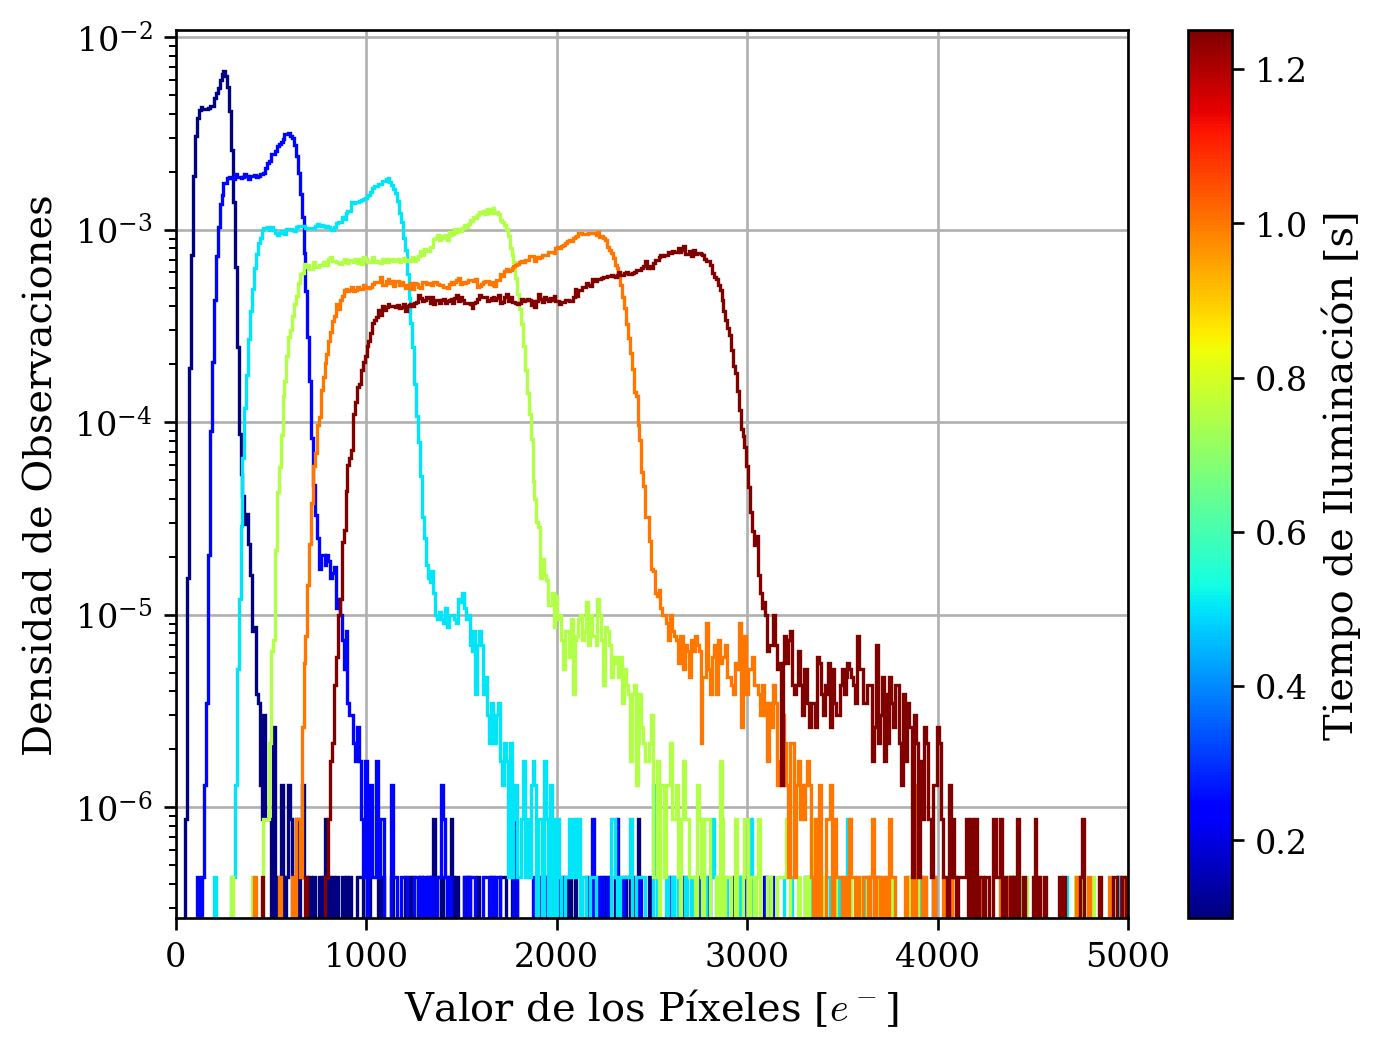

In [51]:
data_dir = 'skipper_data/TRAPS/19OCT2023'


min_val = 0  # e⁻
tope = 5000  # e⁻
n_bins = 500
frame_to_plot = 1
exposure_times = np.array([0.1, 0.25, 0.5, 0.75, 1.0, 1.25])

fig, ax = plt.subplots(1, 1)

norm = plt.Normalize(
        exposure_times.min(),
        exposure_times.max(),
    )
colormap = plt.cm.ScalarMappable(norm, "jet")
for e in exposure_times:
    lighted_image = fits.open(f'{data_dir}/{sgn_files[e]}')
    lighted_image = correct_overscan(lighted_image)
    background_image = fits.open(f'{data_dir}/{bkg_files[e]}')
    background_image = correct_overscan(background_image)

    test_data = lighted_image[frame_to_plot].data
    r_overscan, c_overscan = get_rowcol_ovserscan(lighted_image)
    test_data = test_data[:-r_overscan, PRESCAN_PIX:-c_overscan].flatten()
    if min_val is None:
        min_val = np.nanmin(test_data)
    if tope is None:
        tope = np.nanmax(test_data)
    cuentas, valores, _ = ax.hist(
        test_data[
            (test_data > min_val * ganancia[frame_to_plot])
            & (test_data < tope * ganancia[frame_to_plot])
        ] / ganancia[frame_to_plot],
        bins=np.linspace(min_val, tope, n_bins),
        histtype="step",
        color=colormap.to_rgba(e),
        label=f"{e} s",
        density=True,
    )
    # ax.axvline(test_data.mean() / ganancia[frame_to_plot], color=colormap.to_rgba(e), linestyle="--")
    # ax.axvline((test_data.mean() + 2*test_data.std())  / ganancia[frame_to_plot],
    #            color=colormap.to_rgba(e), linestyle=":")
    # ax.axvline((test_data.mean() - 2*test_data.std())  / ganancia[frame_to_plot],
    #            color=colormap.to_rgba(e), linestyle=":")
ax.grid(True)
# ax.legend(title="Exposure Time")
plt.colorbar(colormap, label="Tiempo de Iluminación [s]", ax=ax)
ax.set_yscale("log")
# ax.set_yticks(10**np.arange(5))
ax.set_xlim(min_val, tope)
ax.set_xlabel("Valor de los Píxeles [$e^-$]")
ax.set_ylabel("Densidad de Observaciones")
plt.show()

In [62]:
frame_to_plot = 1
exposure_times = np.array([0.1, 0.25, 0.5, 0.75, 1.0, 1.25])


carga_media = []
ancho_dist = []
for e in exposure_times:
    lighted_image = fits.open(f'{data_dir}/{sgn_files[e]}')
    lighted_image = correct_overscan(lighted_image)
    background_image = fits.open(f'{data_dir}/{bkg_files[e]}')
    background_image = correct_overscan(background_image)
    test_data = lighted_image[frame_to_plot].data
    r_overscan, c_overscan = get_rowcol_ovserscan(lighted_image)
    test_data = test_data[:-r_overscan, PRESCAN_PIX:-c_overscan].flatten()
    
    carga_media.append(test_data.mean() / ganancia[frame_to_plot])
    ancho_dist.append(test_data.std() / ganancia[frame_to_plot])

Carga Media
Pendiente: 1620 ± 1e+01 e⁻/s
Ordenada : 54 ± 9 e⁻
Ancho de la Distribución
Pendiente: 438 ± 3 e⁻/s
Ordenada : 27 ± 2 e⁻


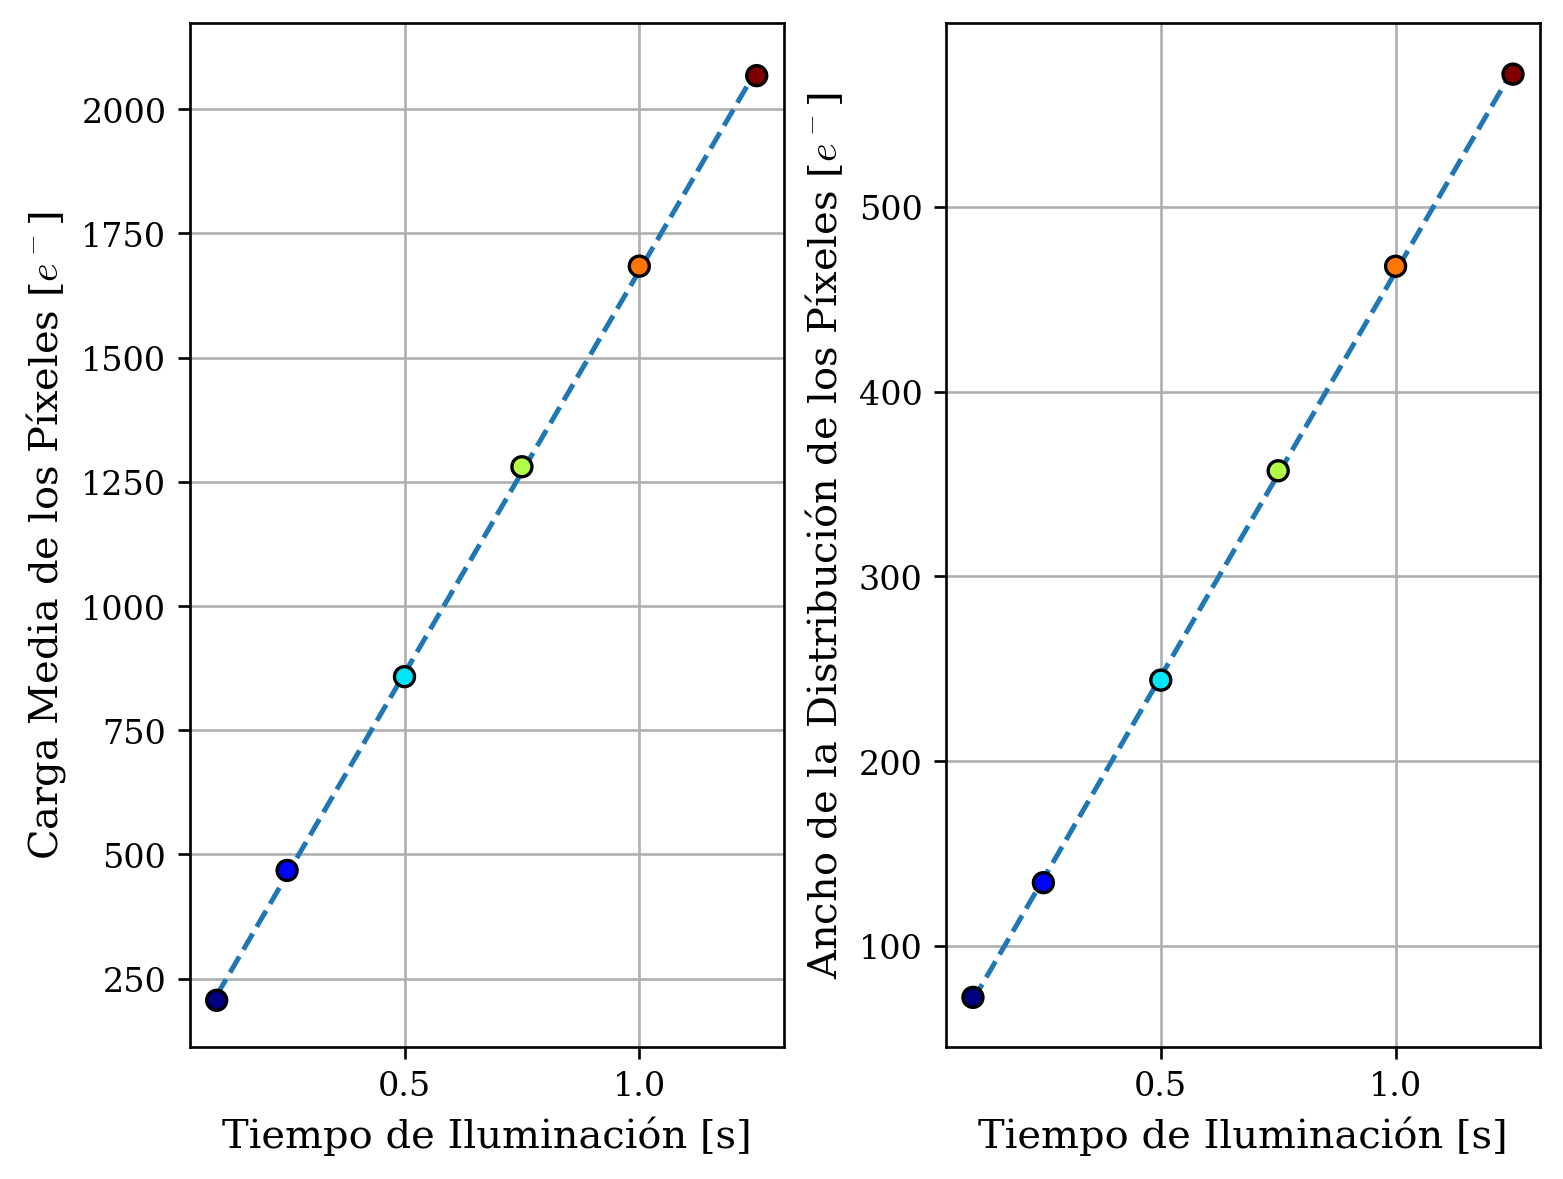

In [79]:
fig, axs = plt.subplots(1, 2, constrained_layout=True)

for ax, vals, tag in zip(axs, [carga_media, ancho_dist], ["Carga Media", "Ancho de la Distribución"]):
    vals = np.array(vals)
    ax.scatter(exposure_times, vals, c=exposure_times, cmap="jet", edgecolors="k", zorder=10)
    popt, pcov = curve_fit(lambda x, a, b: a*x + b, exposure_times, vals)
    perr = np.sqrt(np.diag(pcov))
    print(tag)
    print(f"Pendiente: {popt[0]:.0f} ± {perr[0]:.1g} e⁻/s")
    print(f"Ordenada : {popt[1]:.0f} ± {perr[1]:.1g} e⁻")
    ax.plot(exposure_times, popt[0]*exposure_times + popt[1], linestyle="--", zorder=3)
    ax.grid(True)
    ax.set_xlabel("Tiempo de Iluminación [s]")
    ax.set_ylabel(f"{tag} de los Píxeles [$e^-$]")
plt.show()

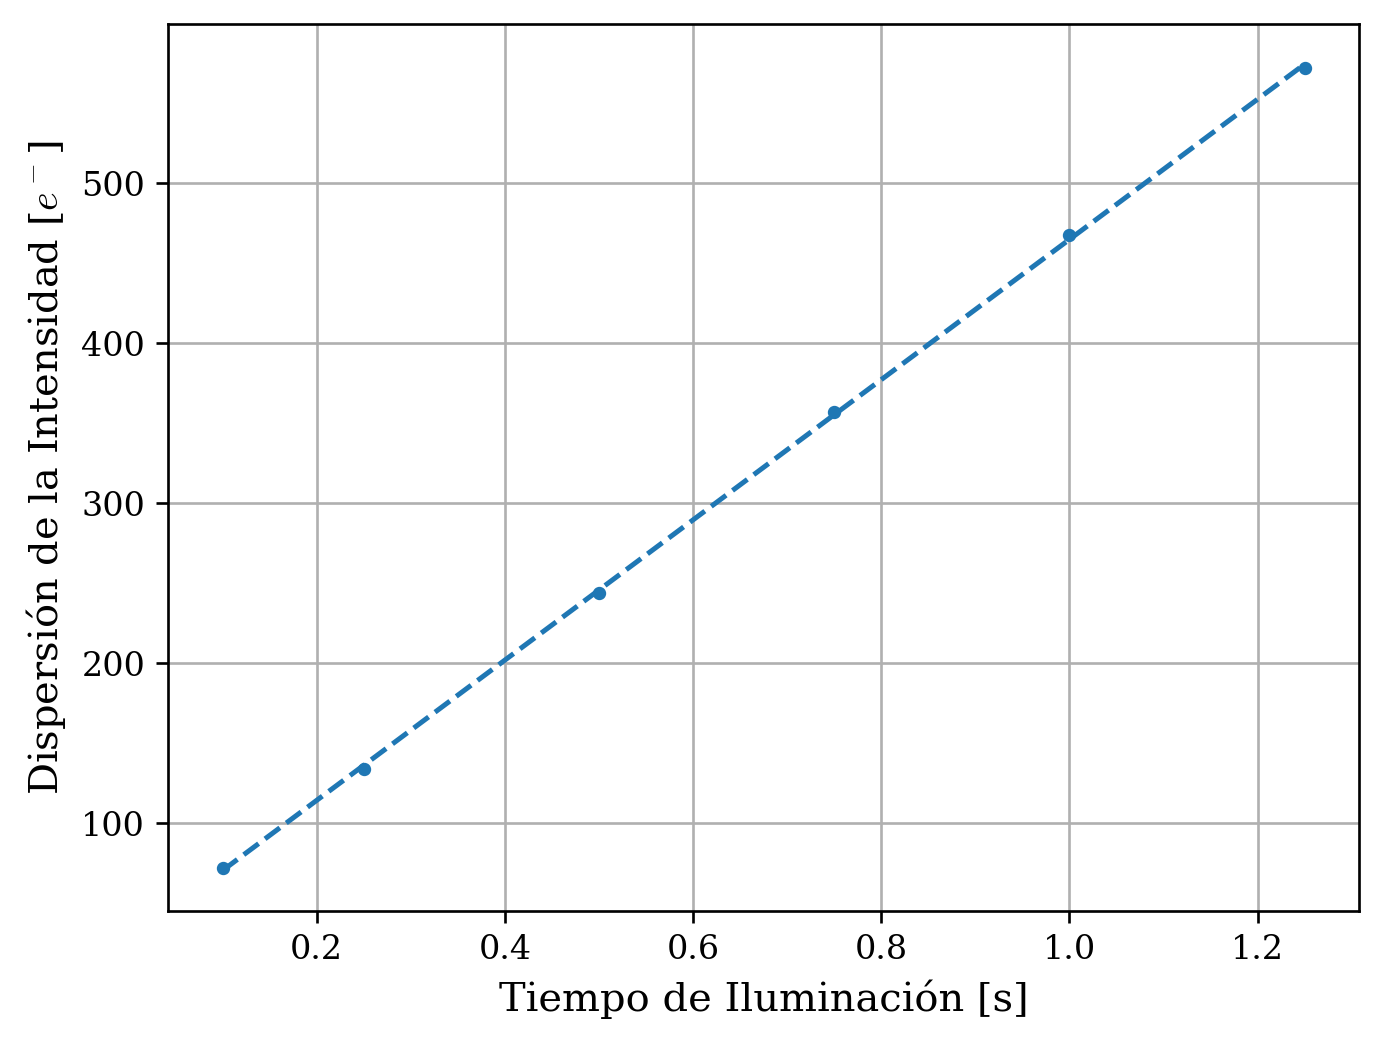

In [59]:
fig, ax = plt.subplots(1, 1)
norm = plt.Normalize(
        exposure_times.min(),
        exposure_times.max(),
    )
colormap = plt.cm.ScalarMappable(norm, "jet")   

popt, pcov = curve_fit(lambda x, a, b: a*x + b, exposure_times, ancho_dist)
perr = np.sqrt(np.diag(pcov))
ax.plot(exposure_times, popt[0]*exposure_times + popt[1], color="C0", linestyle="--")

ax.grid(True)
# ax.legend(title="Exposure Time")
# plt.colorbar(colormap, label="Tiempo de Iluminación [s]", ax=ax)
# ax.set_yticks(10**np.arange(5))
ax.set_xlabel("Tiempo de Iluminación [s]")
ax.set_ylabel("Dispersión de la Intensidad [$e^-$]")
plt.show()